In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
import numpy as np

### Loading Caltech101 Dataset

In [9]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])    
])

dataset = datasets.ImageFolder(root="./images", transform= transform)
len(dataset)

9144

In [11]:
dataset.classes

['BACKGROUND_Google',
 'Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

In [12]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(7315, 1829)

In [14]:
# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])


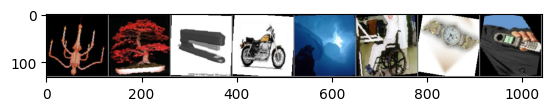

In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# showing images
imshow(torchvision.utils.make_grid(images[:8]))

In [17]:
labels[:8]

tensor([24, 13, 86,  4,  0, 97, 95, 22])

In [18]:
[dataset.classes[i] for i in labels[:8]]

['chandelier',
 'bonsai',
 'stapler',
 'Motorbikes',
 'BACKGROUND_Google',
 'wheelchair',
 'watch',
 'cellphone']

In [23]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=(3,3), padding="same"), # output==> (32, 128, 128)
            nn.ReLU(), 
            nn.MaxPool2d(stride=(2,2), kernel_size=(2,2)), # output==> (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=(3,3), padding="same"), # output==> (64, 64, 64)
            nn.ReLU(), 
            nn.MaxPool2d(stride=(2,2), kernel_size=(2,2)),  # output==> (64, 32, 32)
            
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 256), 
            nn.ReLU(),
            nn.Linear(256, 128), 
            nn.ReLU(),            
            nn.Linear(128, num_classes) 
        )
    
    def forward(self, x):
        return self.network(x)

In [24]:
### Training Loop:

def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs = 5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
           
        print(f"Epochs [{epoch+1}/{num_epochs}], Loss :{running_loss/ len(train_loader):.4f}")   

In [26]:
num_classes = len(dataset.classes)
num_classes

102

In [27]:
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)

Epochs [1/5], Loss :3.3860
Epochs [2/5], Loss :2.5028
Epochs [3/5], Loss :1.9835
Epochs [4/5], Loss :1.6313
Epochs [5/5], Loss :1.3414


In [29]:
def test_model(model, test_loader):
    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            #images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    
test_model(model, test_loader) 

Test Accuracy: 56.48%


### Use Transfer Learning to Boost Performance

#### ResNet18

In [32]:
from torchvision import models

model = models.resnet18(weights="DEFAULT")

model.fc = nn.Linear(model.fc.in_features, num_classes)

In [33]:
#model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)

Epochs [1/5], Loss :1.9213
Epochs [2/5], Loss :1.0250
Epochs [3/5], Loss :0.7158
Epochs [4/5], Loss :0.5500
Epochs [5/5], Loss :0.4313


In [35]:
test_model(model, test_loader)

Test Accuracy: 74.58%


#### EfficientNet_B0

In [37]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
#model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)   
test_model(model, test_loader)

Epochs [1/5], Loss :1.4831
Epochs [2/5], Loss :0.5453
Epochs [3/5], Loss :0.3555
Epochs [4/5], Loss :0.2870
Epochs [5/5], Loss :0.2297
Test Accuracy: 86.33%
